In [13]:
from model import Densenet, ResNet, VGG
from model import dcpResNet
from utils import CovidCTDataset,metrics, SimCLR_loss, LabelSmoothSoftmaxCE
from utils import autoaugment as auto
from model.layer.dcpLayer import dcpConv2D

from torch.utils.data import DataLoader
import argparse
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import torch.nn as nn
import os
import random
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score

from collections import OrderedDict
import matplotlib.pyplot as plt

import gc
import easydict

print("import complete")

import complete


In [14]:

MODEL_DICT = {
    'densenet121': Densenet.densenet121,
    'densenet161': Densenet.densenet161,
    'densenet169': Densenet.densenet169,
    'densenet201': Densenet.densenet201,
    'resnet18': ResNet.resnet18,
    'resnet50': ResNet.resnet50,
    'resnet101': ResNet.resnet101,
    'resnet152': ResNet.resnet152,
    'wide_resnet101': ResNet.wide_resnet101_2,
    'wide_resnet50': ResNet.wide_resnet50_2,
    'vgg16': VGG.vgg16,
}

DCP_MODEL_DICT={
    'resnet18':dcpResNet.resnet18,
    'resnet50':dcpResNet.resnet50,
    'resnet101':dcpResNet.resnet101,
    'resnet152':dcpResNet.resnet152
}

models_config = (
    # model name, model path, weight, data_parallel
    ('resnet152', 'resnet152_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('resnet152', 'resnet152_4_4_crop_480_b16w1.2_pretrained.pt', 1, True),
    ('resnext101', 'resnext101_4_4_crop_480_pretrained.pt', 1, True),
    ('densenet169', 'densenet169-480-moco-soft-COVID.pt', 1, True),
    ('densenet169', 'densenet169_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('densenet169', 'densenet169_soft_480_pretrained.pt', 1, True),
)

def test(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            output = model(img)
            _, preds = torch.max(output, 1)
            avg_val_loss += F.cross_entropy(output, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(output, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def convertPaWeights2NonP(pretrained_state_dict):
  nonpStateDict=OrderedDict()
  for k, v in pretrained_state_dict.items():
    nonpStateDict[k[7:]]=v
  return nonpStateDict

def buildAndTestDCPmodel(model_name, preTrainedModel, test_loader, device, R1_ratio, R2_ratio):
    dcpModel=DCP_MODEL_DICT[model_name](num_classes=2, R1_ratio=R1_ratio, R2_ratio=R2_ratio)
    dcpModel.loadStateFromModel(preTrainedModel)
    if torch.cuda.device_count() > 1:
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        dcpModel = nn.DataParallel(dcpModel).to(device)
    elif torch.cuda.device_count()==1:
        dcpModel.to(device)
    elif torch.cuda.is_available():
        print("GPU detected but cannot use")
    
    AUC, precision, recall, f1, acc, mean_loss = test(dcpModel, 2, test_loader, device)
    acc=acc.numpy().tolist()
    print('Precision {}\tRecall {}\nF1 {}\nAUC {}\tAcc {}\tMean Loss {}'.format(precision, recall, f1, AUC, acc,
                                                                                mean_loss))

    return acc, recall[1]

def saveDCPweights(model_name, preTrainedModel, test_loader, device, R1_ratio, R2_ratio):
    dcpModel=DCP_MODEL_DICT[model_name](num_classes=2, R1_ratio=R1_ratio, R2_ratio=R2_ratio)
    dcpModel.loadStateFromModel(preTrainedModel)
    
    save="checkpoint/CT/%s/%s_R1_%.3f_R2_%.3f.pt"%(model_name,model_name,R1_ratio,R2_ratio)
    print('saving to %s'%(save))
    torch.save(dcpModel.state_dict(),save)

def testAndLoadFromChkpt(model_name, preTrainedModel, test_loader, device, R1_ratio, R2_ratio):
    dcpModel=DCP_MODEL_DICT[model_name](num_classes=2, R1_ratio=R1_ratio, R2_ratio=R2_ratio)
    save="checkpoint/CT/%s/%s_R1_%.3f_R2_%.3f.pt"%(model_name,model_name,R1_ratio,R2_ratio)
    state_dict=torch.load(save)
    dcpModel.load_state_dict(state_dict)

    if torch.cuda.device_count() > 1:
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        dcpModel = nn.DataParallel(dcpModel).to(device)
    elif torch.cuda.device_count()==1:
        dcpModel.to(device)
    elif torch.cuda.is_available():
        print("GPU detected but cannot use")
    
    AUC, precision, recall, f1, acc, mean_loss = test(dcpModel, 2, test_loader, device)
    acc=acc.numpy().tolist()
    print('Precision {}\tRecall {}\nF1 {}\nAUC {}\tAcc {}\tMean Loss {}'.format(precision, recall, f1, AUC, acc,
                                                                                mean_loss))

    return acc, recall[1]

print("define complete")

define complete


In [15]:
args = easydict.EasyDict({
    'model_name':'resnet18',
    'checkpoint_path':'./checkpoint/CT',
    'batch_size':16,
    'lr':1e-4,
    'epoch':50,
    'root_dir':'./COVID-CT/Images-processed',

    'train_COV':'./COVID-CT/Data-split/COVID/trainCT_COVID.txt',
    'train_NonCOV':'./COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',

    'val_COV':'./COVID-CT/Data-split/COVID/valCT_COVID.txt',
    'val_NonCOV':'./COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',

    'test_COV':'./COVID-CT/Data-split/COVID/testCT_COVID.txt',
    'test_NonCOV':'./COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',

    'pretrained':True,
    'save_name':'ResNet18.pt'
})

if not args.pretrained:
    print("The Model Must Be Trained First!")
    quit()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device {}".format(device))
# Create checkpoint file
save_path = os.path.join(args.checkpoint_path, args.model_name)
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                    std=[0.33165374, 0.33165374, 0.33165374])
test_trans = transforms.Compose(
                                [
                                transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                normalize
                                ]
                            )
trainset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.train_COV,
                            txt_NonCOVID=args.train_NonCOV,
                            transform=transforms.Compose(
                                [transforms.RandomResizedCrop((480,480),scale=(0.8,1.2)),
                                    transforms.RandomHorizontalFlip(),
                                    auto.ImageNetPolicy(),
                                    transforms.ToTensor(),
                                    normalize
                                    ]
                            ))
valset = CovidCTDataset(root_dir=args.root_dir,
                        txt_COVID=args.val_COV,
                        txt_NonCOVID=args.val_NonCOV,
                            transform=test_trans
                            )

testset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.test_COV,
                            txt_NonCOVID=args.test_NonCOV,
                            transform=test_trans
                            )

train_loader = DataLoader(trainset,
                            batch_size=args.batch_size,
                            num_workers=8,
                            shuffle=True)
val_loader = DataLoader(valset, batch_size=args.batch_size)
test_loader = DataLoader(testset,batch_size=args.batch_size)

PRINT_INTERVAL = 10
nb_classes = 2
seg_num_class = 2
print(args.model_name,trainset.classes)

model = MODEL_DICT[args.model_name](num_classes=nb_classes, pretrained=args.pretrained)
cntConv=0
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        cntConv+=1
print("In total %d conv"%(cntConv))

# model = Deeplabv3.DeeplabVV3(model, num_class=seg_num_class)
if torch.cuda.device_count() > 1:
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)
    print("Using %d GPUs"%(torch.cuda.device_count()))
elif torch.cuda.device_count()==1:
    model.to(device)
    print("Using 1 GPU")
elif torch.cuda.is_available():
    print("GPU detected but cannot use, use CPU instead")
else:
    print("Using CPU")

optimizer = torch.optim.Adam(model.parameters(),lr = args.lr)
sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("model load complete")

Device cuda
resnet18 ['CT_COVID', 'CT_NonCOVID']
Changing Full Connected
In total 20 conv
Using 1 GPU
model load complete


In [16]:
save = os.path.join(save_path,'{}'.format(args.save_name))

pretrained_state_dict=torch.load(save, map_location=torch.device('cpu'))
if not torch.cuda.is_available():
    pretrained_state_dict=convertPaWeights2NonP(pretrained_state_dict)
model.load_state_dict(pretrained_state_dict)

print("pretrained load complete")

pretrained load complete


In [18]:
yacc,yFNs=[],[]
for dR1 in range(1,9):
    yacc.append([])
    yFNs.append([])
    print("Starting R1=%.3f"%(dR1/8))
    for dR2 in range(1,9):
        r1,r2=dR1/8,dR2/8
        print("R1=%.3f, R2=%.3f"%(r1,r2))
        # saveDCPweights(args.model_name, model, test_loader, device, r1, r2)
        acc,FN=testAndLoadFromChkpt(args.model_name, model, test_loader, device, r1, r2)
        # acc,FN=buildAndTestDCPmodel(args.model_name, model, test_loader, device, r1, r2)
        gc.collect()
        yacc[-1].append(acc)
        yFNs[-1].append(FN)

print("inference complete")

0%|          | 0/13 [00:00<?, ?it/s]Starting R1=0.125
R1=0.125, R2=0.125
  0%|          | 0/13 [00:00<?, ?it/s]tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.598153547133139	Acc 0.48275861144065857	Mean Loss 0.707974699827341
R1=0.125, R2=0.250
  0%|          | 0/13 [00:00<?, ?it/s]tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.6701652089407191	Acc 0.48275861144065857	Mean Loss 0.6970831293326157
R1=0.125, R2=0.375
  0%|          | 0/13 [00:00<?, ?it/s]tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.6648202137998056	Acc 0.48275861144065857	Mean Loss 0.724198932831104
R1=0.125, R2=0.500
  0%|          | 0/13 [00:00<?, ?it/s]tensor([[ 98.,   0.],
        [105.,   0.]])
Precision [1. 0.]	Recall [0.4827586       nan]
F1 [0.65116274        nan]
AUC 0.53517978620

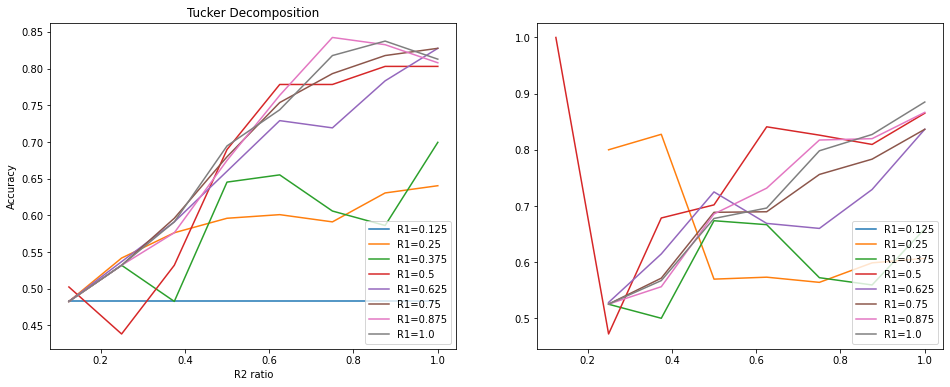

In [20]:
for i in range(8):
    allIsNan=True
    for j in range(8):
        if yacc[i][j]!=np.nan:
            allIsNan=False
            break
    if allIsNan:yacc[i]=None
    allIsNan=True
    for j in range(8):
        if yFNs[i][j]!=np.nan:
            allIsNan=False
            break
    if allIsNan:yFNs[i]=None
xacc=[d/8 for d in range(1,9) if yacc[i] is not None]
xFN=[d/8 for d in range(1,9) if yFNs[i] is not None]

plt.figure(figsize=(16,6))
plt.subplot(121)
for i in range(8):
    if yacc[i] is None:continue
    plt.plot(xacc, yacc[i])
plt.legend(["R1="+str(i/8) for i in range(1,9)], loc='lower right')
plt.title("Tucker Decomposition")
plt.xlabel("R2 ratio")
plt.ylabel("Accuracy")
plt.subplot(122)
for i in range(8):
    if yFNs[i] is None:continue
    plt.plot(xFN,yFNs[i], linestyle='-')
plt.legend(["R1="+str(i/8) for i in range(1,9)], loc='lower right')
plt.show()